# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 2.9MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

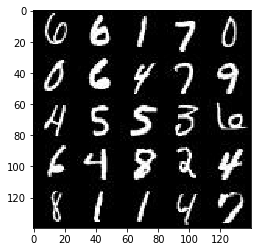

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

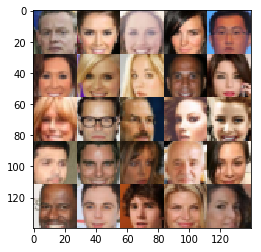

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name= 'z_input')
    learning_rate = tf.placeholder(tf.float32, [], name = 'learning_rate')
    

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [24]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=0.1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=0.1)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=0.1)

        
        flatten = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flatten,1)
        logits = tf.layers.dropout(logits, rate=0.1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [36]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not(is_train)):
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=0.1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=0.1)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=0.1)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training = is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.layers.dropout(x4, rate=0.1)
        
        logits= tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [37]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    
    d_loss_fake =  tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    g_loss =  tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [38]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [40]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    print_at = 25
    show_at = 100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1 
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                                
                #Running g_opt twice so that discriminator does not go to zero
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                
                if steps % print_at == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    
                    print("Epoch: {}/{} ".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}  ".format(train_loss_d),
                          "Generator Loss: {:.4f}   ".format(train_loss_g))

                if steps % show_at == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2  Discriminator Loss: 2.3131   Generator Loss: 0.9965   
Epoch: 1/2  Discriminator Loss: 2.2515   Generator Loss: 0.2321   
Epoch: 1/2  Discriminator Loss: 1.6876   Generator Loss: 1.3830   
Epoch: 1/2  Discriminator Loss: 2.4227   Generator Loss: 0.1697   


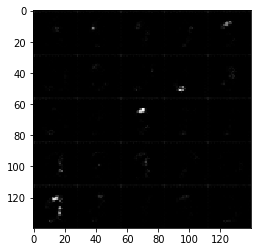

Epoch: 1/2  Discriminator Loss: 2.2230   Generator Loss: 0.2423   
Epoch: 1/2  Discriminator Loss: 1.9320   Generator Loss: 0.3231   
Epoch: 1/2  Discriminator Loss: 1.9935   Generator Loss: 0.6626   
Epoch: 1/2  Discriminator Loss: 1.8076   Generator Loss: 0.7159   


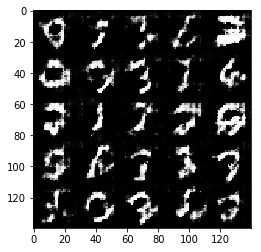

Epoch: 1/2  Discriminator Loss: 1.5845   Generator Loss: 0.5308   
Epoch: 1/2  Discriminator Loss: 1.7605   Generator Loss: 1.1435   
Epoch: 1/2  Discriminator Loss: 1.6853   Generator Loss: 0.6644   
Epoch: 1/2  Discriminator Loss: 1.7411   Generator Loss: 0.5576   


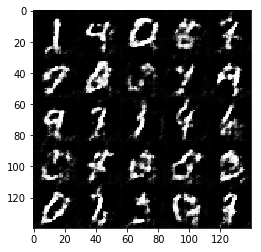

Epoch: 1/2  Discriminator Loss: 1.7652   Generator Loss: 0.5977   
Epoch: 1/2  Discriminator Loss: 1.7451   Generator Loss: 0.3875   
Epoch: 1/2  Discriminator Loss: 1.6126   Generator Loss: 0.4361   
Epoch: 1/2  Discriminator Loss: 1.7937   Generator Loss: 0.3781   


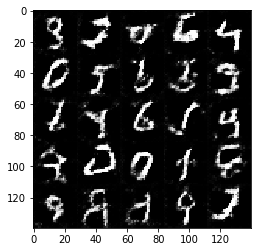

Epoch: 1/2  Discriminator Loss: 1.5710   Generator Loss: 0.8906   
Epoch: 1/2  Discriminator Loss: 1.6136   Generator Loss: 0.4185   
Epoch: 1/2  Discriminator Loss: 1.5867   Generator Loss: 0.5949   
Epoch: 1/2  Discriminator Loss: 1.7347   Generator Loss: 0.7000   


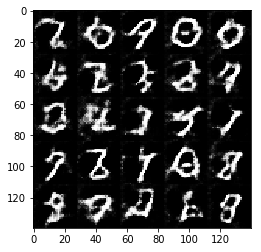

Epoch: 1/2  Discriminator Loss: 1.4895   Generator Loss: 0.9374   
Epoch: 1/2  Discriminator Loss: 1.4597   Generator Loss: 0.7866   
Epoch: 1/2  Discriminator Loss: 1.5362   Generator Loss: 0.7312   
Epoch: 1/2  Discriminator Loss: 1.5549   Generator Loss: 0.5568   


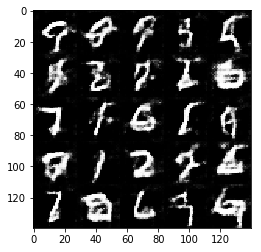

Epoch: 1/2  Discriminator Loss: 2.0320   Generator Loss: 0.2310   
Epoch: 1/2  Discriminator Loss: 1.8872   Generator Loss: 0.2783   
Epoch: 1/2  Discriminator Loss: 1.5561   Generator Loss: 0.9285   
Epoch: 1/2  Discriminator Loss: 1.5287   Generator Loss: 0.9211   


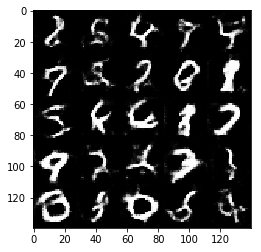

Epoch: 1/2  Discriminator Loss: 1.7333   Generator Loss: 0.3302   
Epoch: 1/2  Discriminator Loss: 1.5489   Generator Loss: 0.6383   
Epoch: 1/2  Discriminator Loss: 1.5785   Generator Loss: 0.4511   
Epoch: 1/2  Discriminator Loss: 1.5105   Generator Loss: 0.5297   


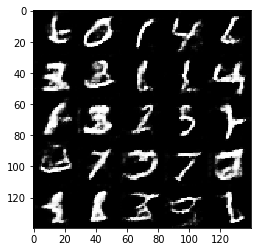

Epoch: 1/2  Discriminator Loss: 1.5765   Generator Loss: 1.3119   
Epoch: 1/2  Discriminator Loss: 1.8335   Generator Loss: 0.3128   
Epoch: 1/2  Discriminator Loss: 1.6415   Generator Loss: 0.6811   
Epoch: 1/2  Discriminator Loss: 1.7100   Generator Loss: 1.3014   


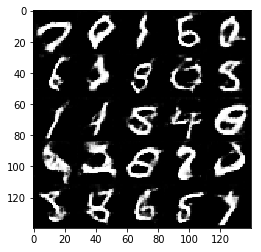

Epoch: 1/2  Discriminator Loss: 1.5402   Generator Loss: 0.5504   
Epoch: 1/2  Discriminator Loss: 1.7939   Generator Loss: 0.3222   
Epoch: 1/2  Discriminator Loss: 1.9484   Generator Loss: 0.2604   
Epoch: 1/2  Discriminator Loss: 1.5682   Generator Loss: 0.5879   


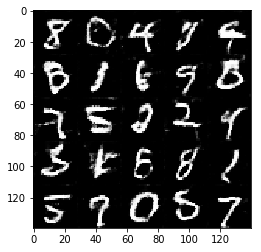

Epoch: 1/2  Discriminator Loss: 1.6835   Generator Loss: 0.3864   
Epoch: 1/2  Discriminator Loss: 1.4562   Generator Loss: 0.7077   
Epoch: 1/2  Discriminator Loss: 1.5538   Generator Loss: 1.2272   
Epoch: 1/2  Discriminator Loss: 1.5136   Generator Loss: 0.5438   


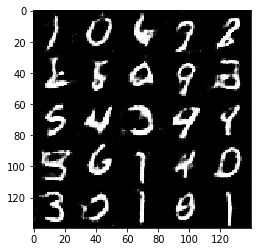

Epoch: 1/2  Discriminator Loss: 1.7558   Generator Loss: 0.3436   
Epoch: 1/2  Discriminator Loss: 1.4717   Generator Loss: 0.7443   
Epoch: 1/2  Discriminator Loss: 1.4967   Generator Loss: 0.5952   
Epoch: 1/2  Discriminator Loss: 1.5493   Generator Loss: 0.4230   


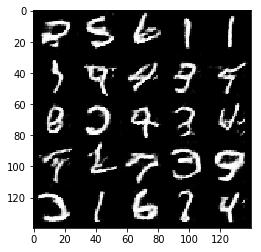

Epoch: 1/2  Discriminator Loss: 1.4651   Generator Loss: 0.5928   
Epoch: 1/2  Discriminator Loss: 1.3966   Generator Loss: 0.5505   
Epoch: 1/2  Discriminator Loss: 1.3662   Generator Loss: 1.0808   
Epoch: 1/2  Discriminator Loss: 1.8855   Generator Loss: 0.2799   


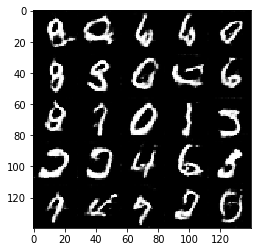

Epoch: 1/2  Discriminator Loss: 1.6215   Generator Loss: 0.4798   
Epoch: 1/2  Discriminator Loss: 1.3470   Generator Loss: 0.6079   
Epoch: 1/2  Discriminator Loss: 1.4446   Generator Loss: 0.6826   
Epoch: 1/2  Discriminator Loss: 1.3618   Generator Loss: 0.6898   


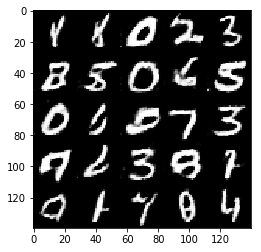

Epoch: 1/2  Discriminator Loss: 1.4291   Generator Loss: 0.6309   
Epoch: 1/2  Discriminator Loss: 1.3733   Generator Loss: 0.7396   
Epoch: 1/2  Discriminator Loss: 1.5862   Generator Loss: 0.5442   
Epoch: 1/2  Discriminator Loss: 1.4809   Generator Loss: 0.5092   


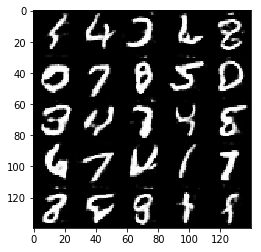

Epoch: 1/2  Discriminator Loss: 1.4662   Generator Loss: 0.6509   
Epoch: 1/2  Discriminator Loss: 1.4880   Generator Loss: 0.5108   
Epoch: 1/2  Discriminator Loss: 1.5122   Generator Loss: 0.6518   
Epoch: 1/2  Discriminator Loss: 1.4520   Generator Loss: 0.5836   


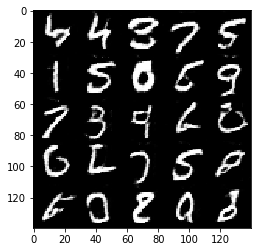

Epoch: 1/2  Discriminator Loss: 1.4604   Generator Loss: 0.7145   
Epoch: 1/2  Discriminator Loss: 1.6082   Generator Loss: 1.5043   
Epoch: 1/2  Discriminator Loss: 1.4947   Generator Loss: 0.6273   
Epoch: 1/2  Discriminator Loss: 1.3382   Generator Loss: 0.8081   


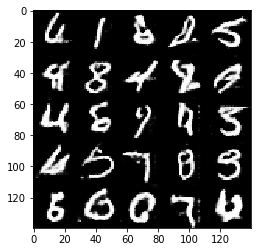

Epoch: 1/2  Discriminator Loss: 1.3958   Generator Loss: 0.8171   
Epoch: 1/2  Discriminator Loss: 1.6173   Generator Loss: 0.4843   
Epoch: 1/2  Discriminator Loss: 1.6362   Generator Loss: 0.3928   
Epoch: 1/2  Discriminator Loss: 1.5567   Generator Loss: 0.4900   


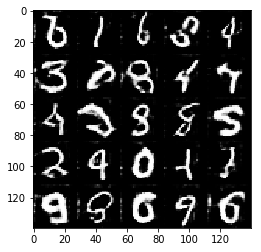

Epoch: 1/2  Discriminator Loss: 1.3192   Generator Loss: 0.5790   
Epoch: 1/2  Discriminator Loss: 1.5791   Generator Loss: 0.6739   
Epoch: 1/2  Discriminator Loss: 1.5419   Generator Loss: 0.5262   
Epoch: 2/2  Discriminator Loss: 2.0285   Generator Loss: 0.2278   


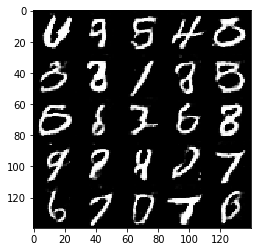

Epoch: 2/2  Discriminator Loss: 1.5015   Generator Loss: 0.5025   
Epoch: 2/2  Discriminator Loss: 1.3860   Generator Loss: 0.8841   
Epoch: 2/2  Discriminator Loss: 1.5005   Generator Loss: 0.5690   
Epoch: 2/2  Discriminator Loss: 1.3979   Generator Loss: 0.5683   


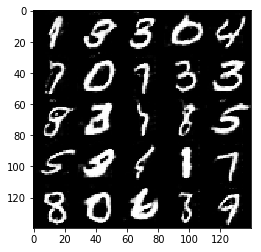

Epoch: 2/2  Discriminator Loss: 1.5781   Generator Loss: 0.4423   
Epoch: 2/2  Discriminator Loss: 1.8286   Generator Loss: 0.2910   
Epoch: 2/2  Discriminator Loss: 1.2225   Generator Loss: 0.7976   
Epoch: 2/2  Discriminator Loss: 1.3310   Generator Loss: 0.6677   


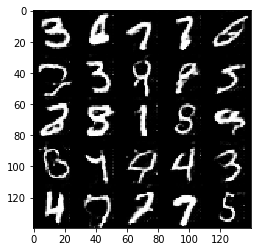

Epoch: 2/2  Discriminator Loss: 1.4940   Generator Loss: 0.5078   
Epoch: 2/2  Discriminator Loss: 1.7282   Generator Loss: 0.3865   
Epoch: 2/2  Discriminator Loss: 1.5104   Generator Loss: 0.8716   
Epoch: 2/2  Discriminator Loss: 1.4011   Generator Loss: 0.5845   


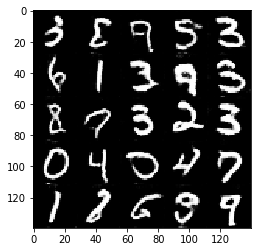

Epoch: 2/2  Discriminator Loss: 1.6323   Generator Loss: 0.4132   
Epoch: 2/2  Discriminator Loss: 1.3007   Generator Loss: 0.6783   
Epoch: 2/2  Discriminator Loss: 1.3327   Generator Loss: 0.6268   
Epoch: 2/2  Discriminator Loss: 1.4565   Generator Loss: 0.5560   


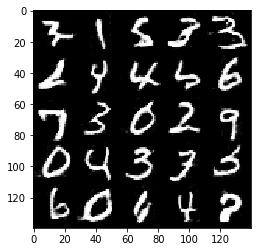

Epoch: 2/2  Discriminator Loss: 1.3185   Generator Loss: 0.7121   
Epoch: 2/2  Discriminator Loss: 1.3868   Generator Loss: 0.5648   
Epoch: 2/2  Discriminator Loss: 1.6030   Generator Loss: 0.4678   
Epoch: 2/2  Discriminator Loss: 1.5767   Generator Loss: 0.4685   


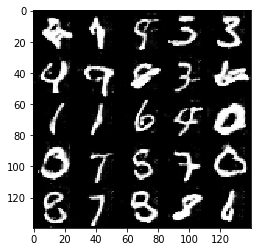

Epoch: 2/2  Discriminator Loss: 1.4275   Generator Loss: 0.6990   
Epoch: 2/2  Discriminator Loss: 1.4705   Generator Loss: 0.6640   
Epoch: 2/2  Discriminator Loss: 1.4317   Generator Loss: 0.7251   
Epoch: 2/2  Discriminator Loss: 1.4781   Generator Loss: 0.6610   


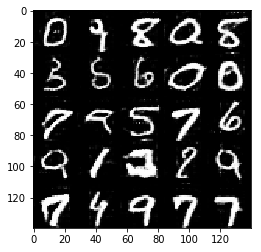

Epoch: 2/2  Discriminator Loss: 1.3244   Generator Loss: 0.6150   
Epoch: 2/2  Discriminator Loss: 1.4489   Generator Loss: 0.6751   
Epoch: 2/2  Discriminator Loss: 1.4443   Generator Loss: 0.6060   
Epoch: 2/2  Discriminator Loss: 1.3275   Generator Loss: 0.5882   


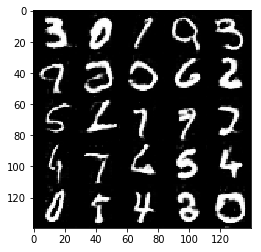

Epoch: 2/2  Discriminator Loss: 1.5429   Generator Loss: 0.4995   
Epoch: 2/2  Discriminator Loss: 1.6709   Generator Loss: 0.4629   
Epoch: 2/2  Discriminator Loss: 1.7848   Generator Loss: 0.3467   
Epoch: 2/2  Discriminator Loss: 1.4939   Generator Loss: 0.7259   


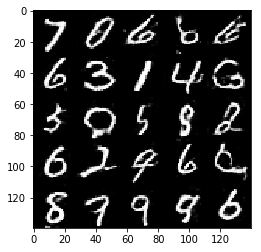

Epoch: 2/2  Discriminator Loss: 1.3924   Generator Loss: 0.6277   
Epoch: 2/2  Discriminator Loss: 1.2770   Generator Loss: 0.9183   
Epoch: 2/2  Discriminator Loss: 1.4334   Generator Loss: 0.6515   
Epoch: 2/2  Discriminator Loss: 1.4956   Generator Loss: 0.5758   


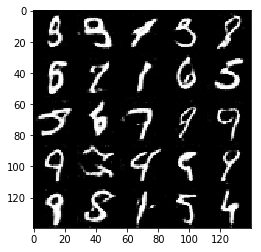

Epoch: 2/2  Discriminator Loss: 1.7659   Generator Loss: 0.3698   
Epoch: 2/2  Discriminator Loss: 1.3207   Generator Loss: 0.5942   
Epoch: 2/2  Discriminator Loss: 1.4679   Generator Loss: 0.5267   
Epoch: 2/2  Discriminator Loss: 1.3234   Generator Loss: 0.9017   


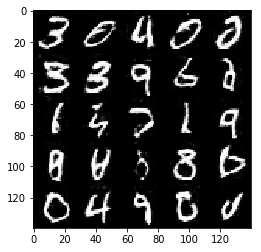

Epoch: 2/2  Discriminator Loss: 1.3441   Generator Loss: 1.0837   
Epoch: 2/2  Discriminator Loss: 1.3966   Generator Loss: 0.6914   
Epoch: 2/2  Discriminator Loss: 1.4799   Generator Loss: 0.6716   
Epoch: 2/2  Discriminator Loss: 2.0476   Generator Loss: 0.2301   


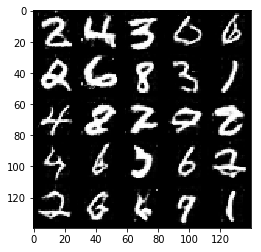

Epoch: 2/2  Discriminator Loss: 1.2829   Generator Loss: 0.8089   
Epoch: 2/2  Discriminator Loss: 1.4200   Generator Loss: 0.5977   
Epoch: 2/2  Discriminator Loss: 1.3687   Generator Loss: 0.7856   
Epoch: 2/2  Discriminator Loss: 1.5645   Generator Loss: 0.5236   


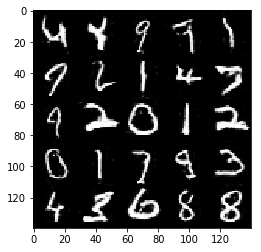

Epoch: 2/2  Discriminator Loss: 1.2456   Generator Loss: 0.7559   
Epoch: 2/2  Discriminator Loss: 1.4715   Generator Loss: 0.5281   
Epoch: 2/2  Discriminator Loss: 1.2086   Generator Loss: 0.8128   
Epoch: 2/2  Discriminator Loss: 1.1991   Generator Loss: 0.7305   


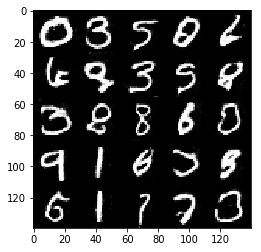

Epoch: 2/2  Discriminator Loss: 1.6246   Generator Loss: 0.4814   
Epoch: 2/2  Discriminator Loss: 1.5045   Generator Loss: 0.5153   
Epoch: 2/2  Discriminator Loss: 1.3572   Generator Loss: 0.6650   
Epoch: 2/2  Discriminator Loss: 1.2540   Generator Loss: 0.7121   


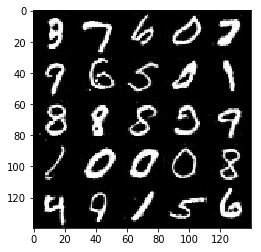

Epoch: 2/2  Discriminator Loss: 1.3733   Generator Loss: 0.6747   
Epoch: 2/2  Discriminator Loss: 1.3231   Generator Loss: 0.5631   
Epoch: 2/2  Discriminator Loss: 1.3839   Generator Loss: 0.7734   
Epoch: 2/2  Discriminator Loss: 1.8091   Generator Loss: 0.3254   


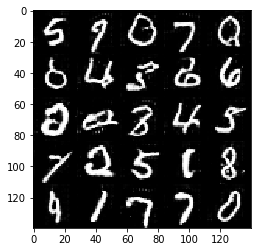

Epoch: 2/2  Discriminator Loss: 1.6461   Generator Loss: 0.4313   
Epoch: 2/2  Discriminator Loss: 1.5030   Generator Loss: 0.4975   
Epoch: 2/2  Discriminator Loss: 1.3602   Generator Loss: 0.8154   
Epoch: 2/2  Discriminator Loss: 1.5240   Generator Loss: 0.4619   


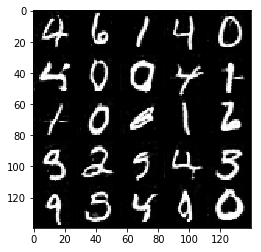

Epoch: 2/2  Discriminator Loss: 1.4933   Generator Loss: 0.5469   
Epoch: 2/2  Discriminator Loss: 1.3335   Generator Loss: 1.2248   
Epoch: 2/2  Discriminator Loss: 2.0316   Generator Loss: 0.2442   
Epoch: 2/2  Discriminator Loss: 1.3599   Generator Loss: 1.2869   


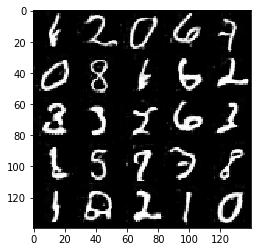

Epoch: 2/2  Discriminator Loss: 1.3673   Generator Loss: 0.8347   
Epoch: 2/2  Discriminator Loss: 1.1495   Generator Loss: 1.2312   
Epoch: 2/2  Discriminator Loss: 1.3857   Generator Loss: 0.6965   
Epoch: 2/2  Discriminator Loss: 1.5027   Generator Loss: 0.7156   


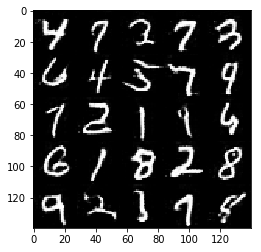

Epoch: 2/2  Discriminator Loss: 1.3273   Generator Loss: 0.8253   
Epoch: 2/2  Discriminator Loss: 1.3976   Generator Loss: 0.6731   


In [41]:
batch_size = 32
z_dim = 128
learning_rate = 0.001 
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1  Discriminator Loss: 2.2667   Generator Loss: 0.4006   
Epoch: 1/1  Discriminator Loss: 1.3693   Generator Loss: 1.0856   
Epoch: 1/1  Discriminator Loss: 1.3523   Generator Loss: 1.6434   
Epoch: 1/1  Discriminator Loss: 1.6638   Generator Loss: 0.4652   


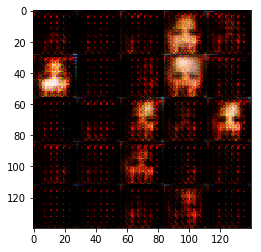

Epoch: 1/1  Discriminator Loss: 1.8515   Generator Loss: 0.4592   
Epoch: 1/1  Discriminator Loss: 1.8137   Generator Loss: 0.6173   
Epoch: 1/1  Discriminator Loss: 1.5776   Generator Loss: 0.7502   
Epoch: 1/1  Discriminator Loss: 2.5563   Generator Loss: 0.3020   


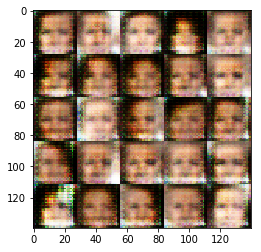

Epoch: 1/1  Discriminator Loss: 1.4828   Generator Loss: 0.5334   
Epoch: 1/1  Discriminator Loss: 1.5307   Generator Loss: 0.9114   
Epoch: 1/1  Discriminator Loss: 1.4736   Generator Loss: 0.9319   
Epoch: 1/1  Discriminator Loss: 1.5817   Generator Loss: 0.7435   


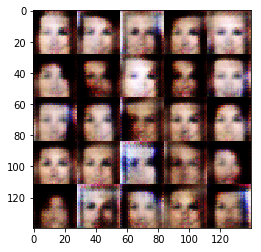

Epoch: 1/1  Discriminator Loss: 1.3215   Generator Loss: 0.7919   
Epoch: 1/1  Discriminator Loss: 1.7000   Generator Loss: 0.3896   
Epoch: 1/1  Discriminator Loss: 1.4709   Generator Loss: 0.6711   
Epoch: 1/1  Discriminator Loss: 1.7155   Generator Loss: 0.6792   


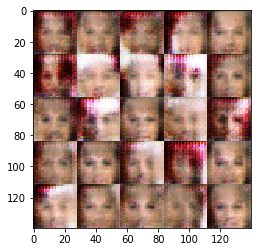

Epoch: 1/1  Discriminator Loss: 1.3737   Generator Loss: 0.7269   
Epoch: 1/1  Discriminator Loss: 1.5707   Generator Loss: 0.7295   
Epoch: 1/1  Discriminator Loss: 1.5088   Generator Loss: 0.7067   
Epoch: 1/1  Discriminator Loss: 1.4940   Generator Loss: 1.0576   


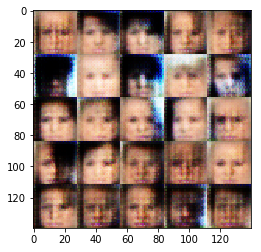

Epoch: 1/1  Discriminator Loss: 1.4005   Generator Loss: 1.3797   
Epoch: 1/1  Discriminator Loss: 1.4330   Generator Loss: 0.8754   
Epoch: 1/1  Discriminator Loss: 1.6547   Generator Loss: 0.5007   
Epoch: 1/1  Discriminator Loss: 1.1018   Generator Loss: 0.8346   


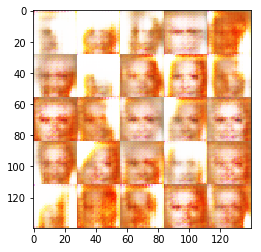

Epoch: 1/1  Discriminator Loss: 2.1604   Generator Loss: 0.2086   
Epoch: 1/1  Discriminator Loss: 1.4194   Generator Loss: 0.8523   
Epoch: 1/1  Discriminator Loss: 1.5960   Generator Loss: 0.4273   
Epoch: 1/1  Discriminator Loss: 1.5932   Generator Loss: 0.4906   


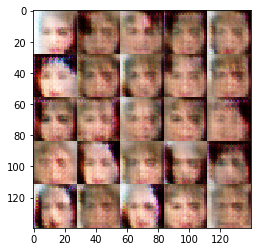

Epoch: 1/1  Discriminator Loss: 1.3652   Generator Loss: 0.7521   
Epoch: 1/1  Discriminator Loss: 1.8516   Generator Loss: 0.7773   
Epoch: 1/1  Discriminator Loss: 1.7928   Generator Loss: 0.4297   
Epoch: 1/1  Discriminator Loss: 1.6378   Generator Loss: 0.6612   


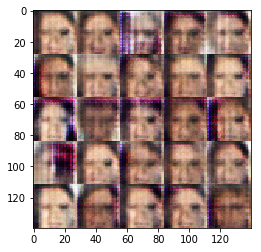

Epoch: 1/1  Discriminator Loss: 1.5634   Generator Loss: 0.4878   
Epoch: 1/1  Discriminator Loss: 1.3992   Generator Loss: 0.7556   
Epoch: 1/1  Discriminator Loss: 1.4405   Generator Loss: 0.7335   
Epoch: 1/1  Discriminator Loss: 1.6320   Generator Loss: 0.5711   


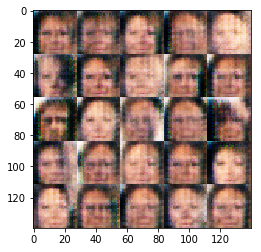

Epoch: 1/1  Discriminator Loss: 1.5077   Generator Loss: 0.6871   
Epoch: 1/1  Discriminator Loss: 1.1981   Generator Loss: 0.9041   
Epoch: 1/1  Discriminator Loss: 1.7266   Generator Loss: 0.6326   
Epoch: 1/1  Discriminator Loss: 1.3888   Generator Loss: 0.8062   


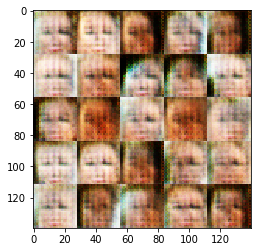

Epoch: 1/1  Discriminator Loss: 1.4927   Generator Loss: 0.6705   
Epoch: 1/1  Discriminator Loss: 1.4457   Generator Loss: 0.6373   
Epoch: 1/1  Discriminator Loss: 1.3415   Generator Loss: 0.8858   
Epoch: 1/1  Discriminator Loss: 1.4178   Generator Loss: 0.9346   


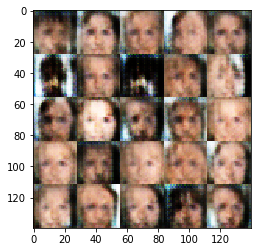

Epoch: 1/1  Discriminator Loss: 1.5072   Generator Loss: 0.7756   
Epoch: 1/1  Discriminator Loss: 1.3844   Generator Loss: 0.6303   
Epoch: 1/1  Discriminator Loss: 1.4883   Generator Loss: 0.6857   
Epoch: 1/1  Discriminator Loss: 1.4857   Generator Loss: 0.8817   


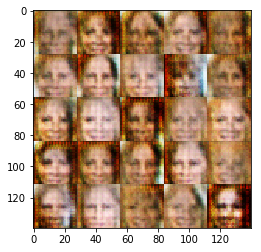

Epoch: 1/1  Discriminator Loss: 1.5856   Generator Loss: 0.5276   
Epoch: 1/1  Discriminator Loss: 1.4478   Generator Loss: 0.9388   
Epoch: 1/1  Discriminator Loss: 1.4606   Generator Loss: 0.6385   
Epoch: 1/1  Discriminator Loss: 1.5463   Generator Loss: 0.7630   


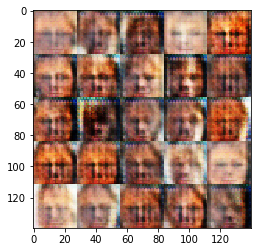

Epoch: 1/1  Discriminator Loss: 1.5302   Generator Loss: 0.8202   
Epoch: 1/1  Discriminator Loss: 1.6460   Generator Loss: 0.9690   
Epoch: 1/1  Discriminator Loss: 1.4179   Generator Loss: 0.7229   
Epoch: 1/1  Discriminator Loss: 1.3460   Generator Loss: 0.7334   


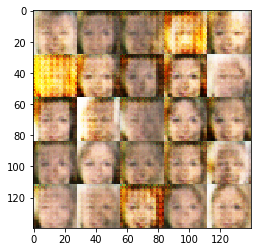

Epoch: 1/1  Discriminator Loss: 1.5296   Generator Loss: 0.5664   
Epoch: 1/1  Discriminator Loss: 1.1123   Generator Loss: 0.8714   
Epoch: 1/1  Discriminator Loss: 1.5819   Generator Loss: 0.6763   
Epoch: 1/1  Discriminator Loss: 1.3149   Generator Loss: 0.7827   


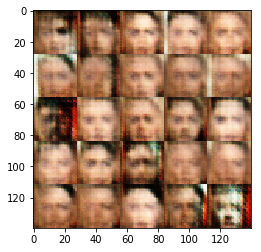

Epoch: 1/1  Discriminator Loss: 1.6659   Generator Loss: 0.5340   
Epoch: 1/1  Discriminator Loss: 1.4838   Generator Loss: 0.8723   
Epoch: 1/1  Discriminator Loss: 1.4566   Generator Loss: 0.7791   
Epoch: 1/1  Discriminator Loss: 1.4426   Generator Loss: 0.7299   


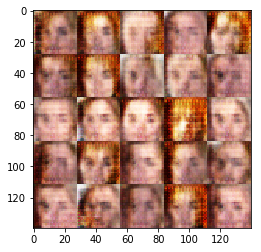

Epoch: 1/1  Discriminator Loss: 1.5841   Generator Loss: 0.5534   
Epoch: 1/1  Discriminator Loss: 1.4814   Generator Loss: 0.6402   
Epoch: 1/1  Discriminator Loss: 1.5381   Generator Loss: 1.0900   
Epoch: 1/1  Discriminator Loss: 1.3561   Generator Loss: 0.7204   


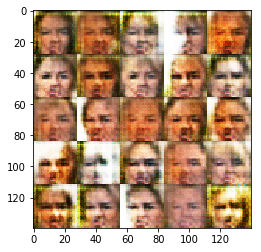

Epoch: 1/1  Discriminator Loss: 1.4644   Generator Loss: 0.8018   
Epoch: 1/1  Discriminator Loss: 1.4939   Generator Loss: 0.8090   
Epoch: 1/1  Discriminator Loss: 1.4427   Generator Loss: 0.8372   
Epoch: 1/1  Discriminator Loss: 1.3577   Generator Loss: 0.7216   


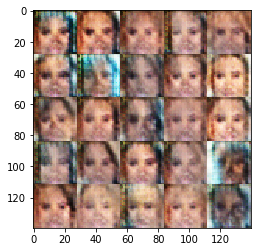

Epoch: 1/1  Discriminator Loss: 1.3915   Generator Loss: 0.7663   
Epoch: 1/1  Discriminator Loss: 1.4827   Generator Loss: 0.5404   
Epoch: 1/1  Discriminator Loss: 1.3713   Generator Loss: 0.8730   
Epoch: 1/1  Discriminator Loss: 1.4138   Generator Loss: 0.7312   


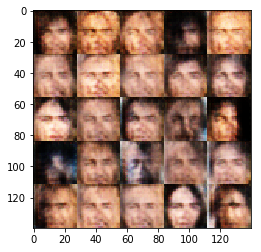

Epoch: 1/1  Discriminator Loss: 1.3299   Generator Loss: 0.9000   
Epoch: 1/1  Discriminator Loss: 1.5515   Generator Loss: 0.6230   
Epoch: 1/1  Discriminator Loss: 1.4356   Generator Loss: 0.7899   
Epoch: 1/1  Discriminator Loss: 1.5958   Generator Loss: 0.6112   


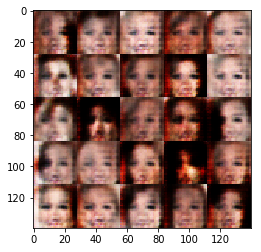

Epoch: 1/1  Discriminator Loss: 1.3476   Generator Loss: 0.8073   
Epoch: 1/1  Discriminator Loss: 1.4525   Generator Loss: 0.5941   
Epoch: 1/1  Discriminator Loss: 1.5134   Generator Loss: 0.5106   
Epoch: 1/1  Discriminator Loss: 0.9300   Generator Loss: 0.8765   


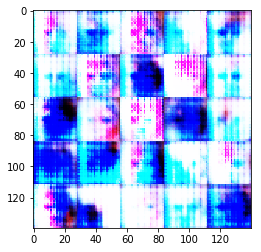

Epoch: 1/1  Discriminator Loss: 1.5209   Generator Loss: 0.4965   
Epoch: 1/1  Discriminator Loss: 0.7901   Generator Loss: 1.2292   
Epoch: 1/1  Discriminator Loss: 1.6159   Generator Loss: 1.5217   
Epoch: 1/1  Discriminator Loss: 1.4874   Generator Loss: 0.8903   


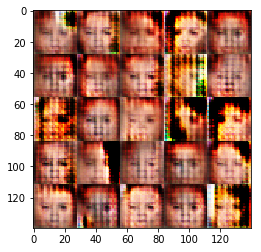

Epoch: 1/1  Discriminator Loss: 1.4581   Generator Loss: 0.6329   
Epoch: 1/1  Discriminator Loss: 1.1323   Generator Loss: 0.9827   
Epoch: 1/1  Discriminator Loss: 1.6611   Generator Loss: 1.2133   
Epoch: 1/1  Discriminator Loss: 1.4375   Generator Loss: 0.9863   


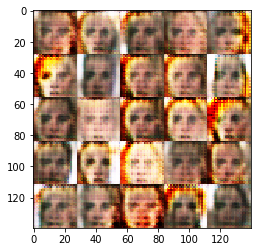

Epoch: 1/1  Discriminator Loss: 1.3582   Generator Loss: 0.7954   
Epoch: 1/1  Discriminator Loss: 1.3321   Generator Loss: 0.9044   
Epoch: 1/1  Discriminator Loss: 1.2926   Generator Loss: 1.0045   
Epoch: 1/1  Discriminator Loss: 1.2263   Generator Loss: 0.7802   


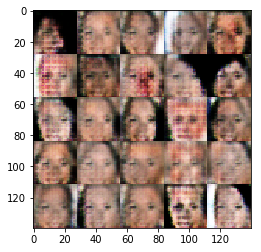

Epoch: 1/1  Discriminator Loss: 1.2888   Generator Loss: 1.0179   
Epoch: 1/1  Discriminator Loss: 1.3064   Generator Loss: 0.7425   
Epoch: 1/1  Discriminator Loss: 1.3064   Generator Loss: 1.1038   
Epoch: 1/1  Discriminator Loss: 1.4240   Generator Loss: 0.6748   


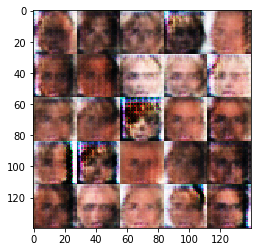

Epoch: 1/1  Discriminator Loss: 1.2443   Generator Loss: 0.7929   
Epoch: 1/1  Discriminator Loss: 1.2823   Generator Loss: 0.9285   
Epoch: 1/1  Discriminator Loss: 1.2792   Generator Loss: 0.6848   
Epoch: 1/1  Discriminator Loss: 1.5117   Generator Loss: 0.6287   


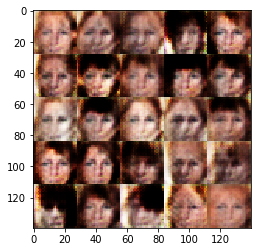

Epoch: 1/1  Discriminator Loss: 1.2175   Generator Loss: 0.8967   
Epoch: 1/1  Discriminator Loss: 1.4330   Generator Loss: 0.9679   
Epoch: 1/1  Discriminator Loss: 1.2605   Generator Loss: 0.7758   
Epoch: 1/1  Discriminator Loss: 1.3379   Generator Loss: 0.7697   


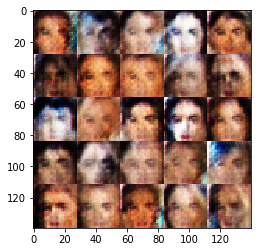

Epoch: 1/1  Discriminator Loss: 1.1007   Generator Loss: 0.8831   
Epoch: 1/1  Discriminator Loss: 1.2676   Generator Loss: 0.7894   
Epoch: 1/1  Discriminator Loss: 1.3748   Generator Loss: 0.8862   
Epoch: 1/1  Discriminator Loss: 1.3222   Generator Loss: 0.6786   


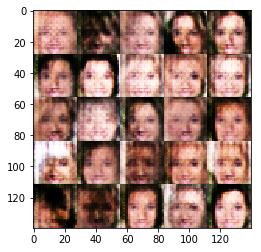

Epoch: 1/1  Discriminator Loss: 1.4805   Generator Loss: 0.7399   
Epoch: 1/1  Discriminator Loss: 1.9687   Generator Loss: 0.4211   
Epoch: 1/1  Discriminator Loss: 1.3758   Generator Loss: 0.7940   
Epoch: 1/1  Discriminator Loss: 1.2940   Generator Loss: 0.6907   


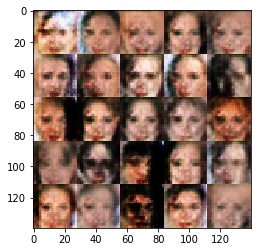

Epoch: 1/1  Discriminator Loss: 1.6705   Generator Loss: 0.5840   
Epoch: 1/1  Discriminator Loss: 1.4900   Generator Loss: 0.5967   
Epoch: 1/1  Discriminator Loss: 1.3561   Generator Loss: 0.9304   
Epoch: 1/1  Discriminator Loss: 1.4624   Generator Loss: 0.7727   


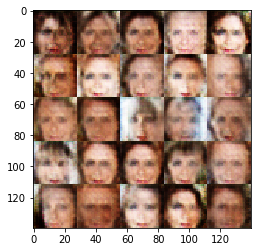

Epoch: 1/1  Discriminator Loss: 1.5422   Generator Loss: 0.7160   
Epoch: 1/1  Discriminator Loss: 1.3443   Generator Loss: 0.8000   
Epoch: 1/1  Discriminator Loss: 1.2267   Generator Loss: 1.0688   
Epoch: 1/1  Discriminator Loss: 1.4550   Generator Loss: 0.7919   


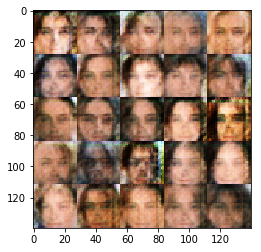

Epoch: 1/1  Discriminator Loss: 1.3792   Generator Loss: 0.7517   
Epoch: 1/1  Discriminator Loss: 1.3891   Generator Loss: 0.7219   
Epoch: 1/1  Discriminator Loss: 1.2064   Generator Loss: 0.8190   
Epoch: 1/1  Discriminator Loss: 1.3614   Generator Loss: 0.8413   


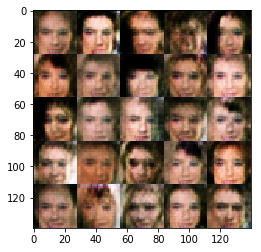

Epoch: 1/1  Discriminator Loss: 1.3861   Generator Loss: 0.8253   
Epoch: 1/1  Discriminator Loss: 1.4471   Generator Loss: 0.8101   
Epoch: 1/1  Discriminator Loss: 1.5149   Generator Loss: 0.7008   
Epoch: 1/1  Discriminator Loss: 1.4942   Generator Loss: 0.6980   


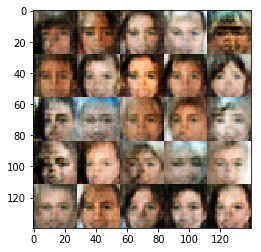

Epoch: 1/1  Discriminator Loss: 1.3029   Generator Loss: 0.8293   
Epoch: 1/1  Discriminator Loss: 1.2985   Generator Loss: 0.7232   
Epoch: 1/1  Discriminator Loss: 1.5595   Generator Loss: 0.6727   
Epoch: 1/1  Discriminator Loss: 1.3795   Generator Loss: 0.7360   


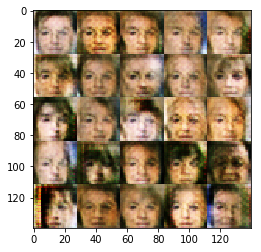

Epoch: 1/1  Discriminator Loss: 1.4645   Generator Loss: 0.6640   
Epoch: 1/1  Discriminator Loss: 1.3110   Generator Loss: 0.8781   
Epoch: 1/1  Discriminator Loss: 1.4160   Generator Loss: 0.8519   
Epoch: 1/1  Discriminator Loss: 1.2285   Generator Loss: 0.9173   


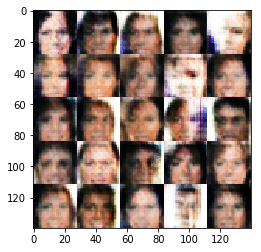

Epoch: 1/1  Discriminator Loss: 1.3242   Generator Loss: 0.8140   
Epoch: 1/1  Discriminator Loss: 1.4536   Generator Loss: 0.7726   
Epoch: 1/1  Discriminator Loss: 1.3767   Generator Loss: 0.7804   
Epoch: 1/1  Discriminator Loss: 1.3690   Generator Loss: 0.7254   


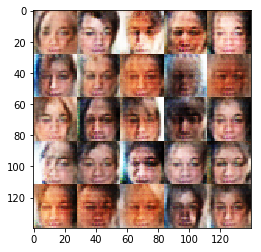

Epoch: 1/1  Discriminator Loss: 1.3625   Generator Loss: 0.7902   
Epoch: 1/1  Discriminator Loss: 1.3303   Generator Loss: 0.7504   
Epoch: 1/1  Discriminator Loss: 1.4472   Generator Loss: 0.8073   
Epoch: 1/1  Discriminator Loss: 1.3198   Generator Loss: 0.7348   


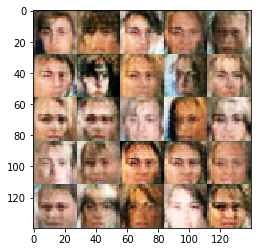

Epoch: 1/1  Discriminator Loss: 1.3596   Generator Loss: 0.8449   
Epoch: 1/1  Discriminator Loss: 1.3832   Generator Loss: 0.7254   
Epoch: 1/1  Discriminator Loss: 1.3623   Generator Loss: 0.8255   
Epoch: 1/1  Discriminator Loss: 1.3930   Generator Loss: 0.7921   


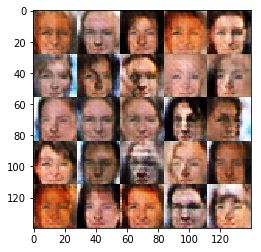

Epoch: 1/1  Discriminator Loss: 1.3974   Generator Loss: 0.6935   
Epoch: 1/1  Discriminator Loss: 1.5698   Generator Loss: 0.7191   
Epoch: 1/1  Discriminator Loss: 1.4233   Generator Loss: 0.8196   
Epoch: 1/1  Discriminator Loss: 1.4079   Generator Loss: 0.7495   


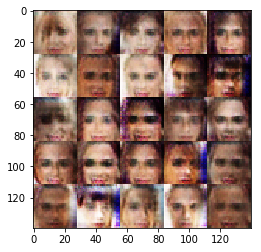

Epoch: 1/1  Discriminator Loss: 1.4452   Generator Loss: 0.7042   
Epoch: 1/1  Discriminator Loss: 1.4197   Generator Loss: 0.7403   
Epoch: 1/1  Discriminator Loss: 1.3460   Generator Loss: 0.8301   
Epoch: 1/1  Discriminator Loss: 1.3583   Generator Loss: 0.7743   


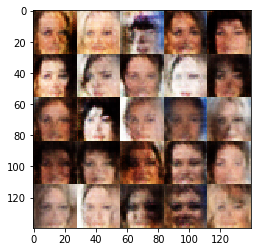

KeyboardInterrupt: 

In [42]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.